# Numerical Project TFY4240 Sindre Lothe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List

newparams = {'figure.figsize': (12, 8), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

## Part 0: Theory

Using variables $\xi = x/L$, $\lambda = y/L$.

The equation we want to solve is 

$\nabla^2 V = 0$,

with boundary conditions 

$V(x=0, y)=0$,

$V(x=L, y)=0$,

$V(x, y=0)=0$,

$V(x, y=L)=V_0(x)$.

This results in solutions of the form 

$V(\xi, \lambda) = \sum_{n=1}^{\infty} A_n \sinh(n \pi \lambda) \sin(n \pi \xi)$,

where 

$A_n = \frac{2}{\sinh(n \pi)} \int_0^1 V_0(\xi L) \sin(n \pi \xi) d\xi$.

This also means that 


$\bm{E} = - \nabla V = -\frac{\partial V}{\partial x} \hat{x} - \frac{\partial V}{\partial y} \hat{y} = -\frac{\partial \xi}{\partial x}\frac{\partial V}{\partial \xi} \hat{x} - \frac{\partial \lambda}{\partial y}\frac{\partial V}{\partial \lambda} \hat{y}$,

which gives 


$\bm{E} = -\frac{1}{L}\frac{\partial V}{\partial \xi} \hat{x} - \frac{1}{L}\frac{\partial V}{\partial \lambda} \hat{y}$.

The final equations for the electric field is therefore 

$E_x(\xi, \lambda) = -\sum_{n=1}^{\infty} A_n \frac{n \pi}{L} \sinh(n \pi \lambda) \cos(n \pi \xi)$,

$E_y(\xi, \lambda) = -\sum_{n=1}^{\infty} A_n \frac{n \pi}{L} \cosh(n \pi \lambda) \sin(n \pi \xi)$.


## Part 1: Defining functions

The code below is a potential class, which takes in $N$, the number of terms in the Fourier series. It has a method called calculateCoefficients, which calculates the Fourier coefficients corresponding to $A_n$ above for a given potential $V_0(x)$ as a boundary condition. After that has been called we can use the functions V, Ex and Ey to find the potential and the electric field in x and y direction. 

The next block defines a function which uses the potential class to return the potential, the electric field and a coordinate system for a given number of Fourier coefficients and a given number of points in the coordinate system. 

In [2]:
class Potential:
    def __init__(self, N: int):
        self.coefficients_array: np.ndarray = np.zeros(N)
        self.N: int = N
        self.V: Callable[[float, float], float] = np.vectorize(self.scalar_V)
        self.Ex: Callable[[float, float], float] = np.vectorize(self.scalar_Ex)
        self.Ey: Callable[[float, float], float] = np.vectorize(self.scalar_Ey)


    def scalar_V(self, xi: float, lambd: float) -> float:
        return np.sum(self.coefficients_array * np.sinh([n*np.pi*lambd for n in range(1, self.N+1)]) * np.sin([n*np.pi*xi for n in range(1, self.N+1)]))

    def scalar_Ex(self, xi: float, lambd: float) -> float:
        return -np.sum(self.coefficients_array * np.sinh([n*np.pi*lambd for n in range(1, self.N+1)]) * np.cos([n*np.pi*xi for n in range(1, self.N+1)])*np.array([n for n in range(1, self.N+1)]))*np.pi

    def scalar_Ey(self, xi: float, lambd: float) -> float:
        return -np.sum(self.coefficients_array * np.cosh([n*np.pi*lambd for n in range(1, self.N+1)]) * np.sin([n*np.pi*xi for n in range(1, self.N+1)])*np.array([n for n in range(1, self.N+1)]))*np.pi
        
    def calculateCoefficients(self, V0: Callable[[float], float], M: int) -> None:
        xi_array: np.ndarray = np.linspace(0, 1, M)
        V0_array: np.ndarray = V0(xi_array)
        a_next: float = 0 
        for n in range(1, self.N+1):
            sin_array: np.ndarray = np.sin(n*np.pi*xi_array)
            a_next = np.sum(2/np.sinh(n*np.pi) * sin_array * V0_array/M)
            self.coefficients_array[n-1] = a_next


In [26]:
def calculatePotentialAndEField(numer_of_fourier: int, number_of_points: int, V0_func: Callable[[float], float]) -> List[np.ndarray]:   
    xi_array: np.ndarray = np.linspace(0, 1, number_of_points)
    lambd_array: np.ndarray = np.linspace(0, 1, number_of_points)

    xx, yy = np.meshgrid(xi_array, lambd_array)

    Pot: Potential = Potential(numer_of_fourier)
    Pot.calculateCoefficients(V0_func, M)

    V_matrix: np.ndarray = Pot.V(xx, yy)
    Ex_matrix: np.ndarray = Pot.Ex(xx, yy)
    Ey_matrix: np.ndarray = Pot.Ey(xx, yy)

    return V_matrix, Ex_matrix, Ey_matrix, xx, yy
    
def plotVectorField(vx_matrix: np.ndarray, vy_matrix: np.ndarray, number_of_vectors: int = 10, levels: int = 100, xlabel: str = None, ylabel: str = None, zlabel: str = None, savestring: str = None):
    M = vx_matrix[0].size
    slice = lambda arr : arr[::int(M/number_of_vectors), ::int(M/number_of_vectors)]
    v_matrix = np.linalg.norm([vx_matrix, vy_matrix], axis=0)
    args = [xx, yy, vx_matrix/v_matrix, vy_matrix/v_matrix]

    plt.quiver(*[slice(a) for a in args])
    plt.contour(xx, yy, v_matrix, levels=levels)
    cbar: plt.colorbar = plt.colorbar()
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if zlabel:
        cbar.set_label(zlabel)
    if savestring:
        plt.savefig(savestring)
    plt.show()

def findConvergenceErrors(number_of_fourier: int, number_of_points: int, V0_func: Callable[[float], float], step_size: int) -> List[np.ndarray]:
    xi_array: np.ndarray = np.linspace(0, 1, number_of_points)
    lambd_array: np.ndarray = np.linspace(0, 1, number_of_points)

    xx, yy = np.meshgrid(xi_array, lambd_array)

    V0_array: np.ndarray = V0_func(xi_array)
    N_array = np.arange(1, number_of_fourier, step_size)
    error_array: np.ndarray = np.zeros(N_array.shape[0])
    for i, n in enumerate(N_array):
        Pot: Potential = Potential(n)
        Pot.calculateCoefficients(V0_func, M)
        V_matrix: np.ndarray = Pot.V(xx, yy)
        error_array[i] = np.linalg.norm(V_matrix[-1, :] - V0_array)
    
    return error_array, N_array
 


## Part 2: Different Potentials

### 2.1: First potential

The first potential to be examined is $V_0(x) = V_c (1-(x/L - 0.5)^4)$.

In [23]:
M: int = 500
N: int = 100

def V1(xi: float) -> float:
    return 1 - (xi - 0.5)**4

V_matrix, Ex_matrix, Ey_matrix, xx, yy = calculatePotentialAndEField(N, M, V1)

In [5]:
error_array, N_array = findConvergenceErrors(N, M, V1, 5)

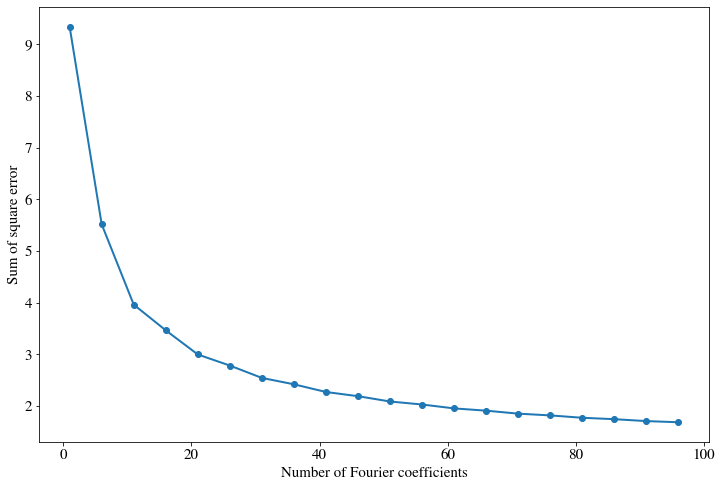

In [6]:
plt.plot(N_array, error_array, "o-")
plt.xlabel("Number of Fourier coefficients")
plt.ylabel("Sum of square error")
plt.savefig("pot1_error.pdf")

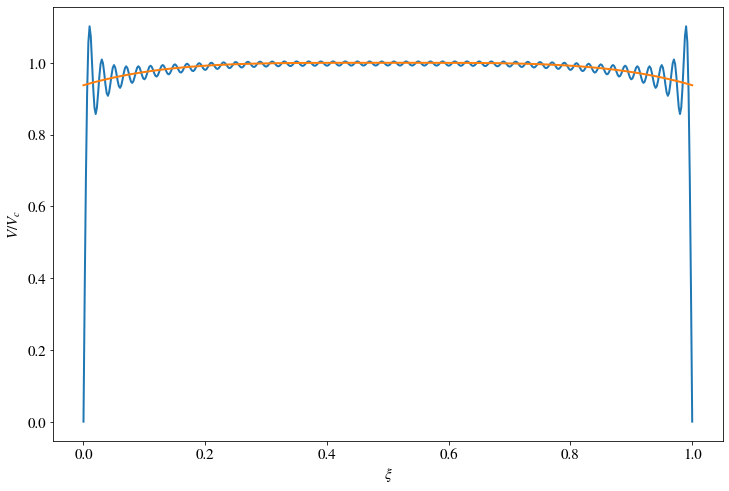

In [25]:
plt.plot(xx[0], V_matrix[-1, :])
plt.plot(xx[0], V1(xx[0]))
plt.xlabel(r"$\xi$")
plt.ylabel(r"$V / V_c$")
plt.savefig("pot1_xat0.pdf")
plt.show()

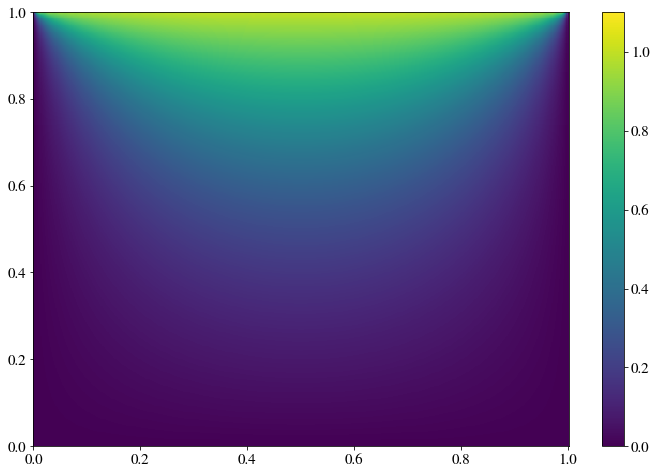

In [6]:
plt.pcolormesh(xx, yy, V_matrix)
plt.colorbar()
plt.show()

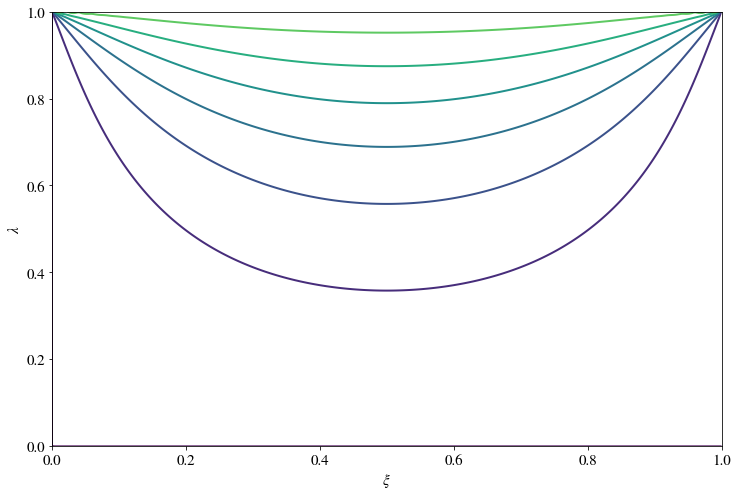

In [24]:
plt.contour(xx, yy, V_matrix)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\lambda$")
plt.savefig("pot1_contour.pdf")
plt.show()

/tmp/ipykernel_361/2672638693.py:20: RuntimeWarning: invalid value encountered in true_divide
  args = [xx, yy, vx_matrix/v_matrix, vy_matrix/v_matrix]


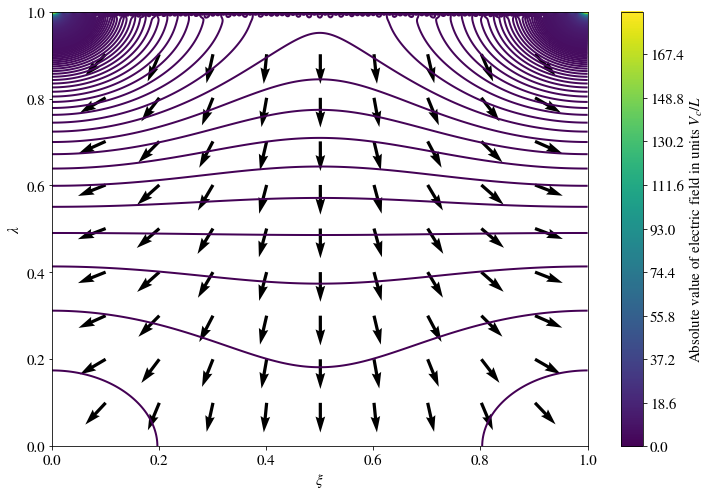

In [27]:
K = 10
plotVectorField(Ex_matrix, Ey_matrix, number_of_vectors=K, levels=1000, xlabel=r"$\xi$", ylabel=r"$\lambda$", zlabel=r"Absolute value of electric field in units $V_c / L$", savestring="pot1_efield.pdf")

### 2.2: Second potential

The second potential to be examined is $V_0(x) = V_c \theta(x - L/2) \theta(3L/4 - x)$, where $\theta(x)$ is the Heaviside step function.

In [28]:
M: int = 500
N: int = 100

def V2(xi: float) -> float:
    return np.heaviside(xi - 0.5, 0.5)*np.heaviside(0.75 - xi, 0.5)

V_matrix, Ex_matrix, Ey_matrix, xx, yy = calculatePotentialAndEField(N, M, V2)

In [16]:
error_array, N_array = findConvergenceErrors(N, M, V2, 5)

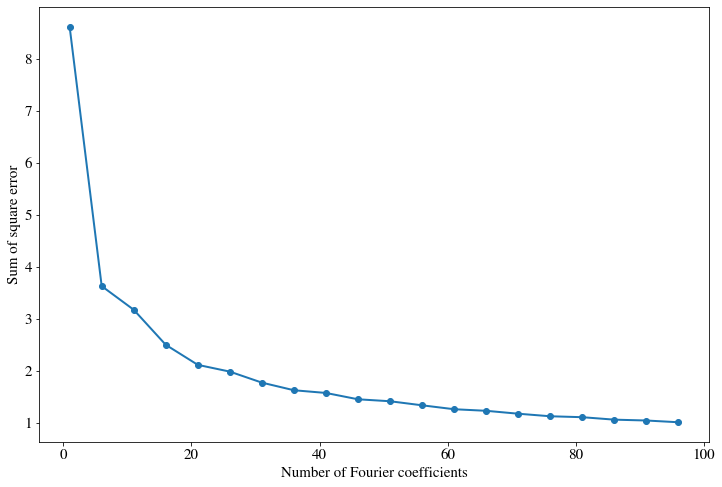

In [17]:
plt.plot(N_array, error_array, "o-")
plt.xlabel("Number of Fourier coefficients")
plt.ylabel("Sum of square error")
plt.savefig("pot2_error.pdf")

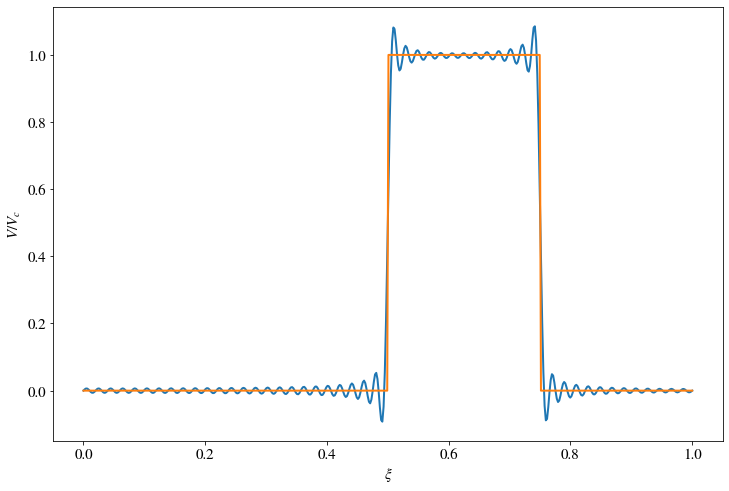

In [19]:
plt.plot(xx[0], V_matrix[-1, :])
plt.plot(xx[0], V2(xx[0]))
plt.xlabel(r"$\xi$")
plt.ylabel(r"$V / V_c$")
plt.savefig("pot2_xat0.pdf")
plt.show()

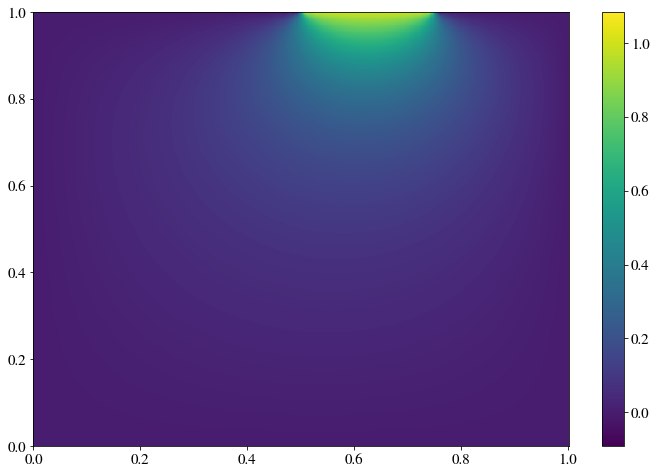

In [47]:
plt.pcolormesh(xx, yy, V_matrix)
plt.colorbar()
plt.show()

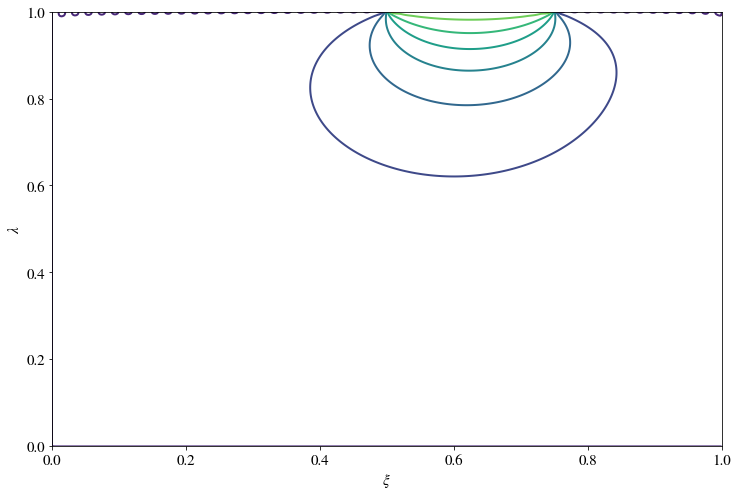

In [22]:
plt.contour(xx, yy, V_matrix)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\lambda$")
plt.savefig("pot2_contour.pdf")
plt.show()

/tmp/ipykernel_361/2672638693.py:20: RuntimeWarning: invalid value encountered in true_divide
  args = [xx, yy, vx_matrix/v_matrix, vy_matrix/v_matrix]


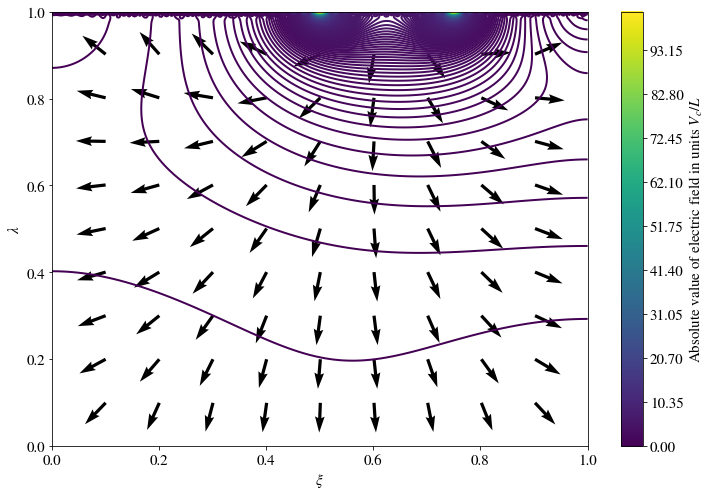

In [29]:
K = 10

plotVectorField(Ex_matrix, Ey_matrix, number_of_vectors=K, levels=1000, xlabel=r"$\xi$", ylabel=r"$\lambda$", zlabel=r"Absolute value of electric field in units $V_c / L$", savestring="pot2_efield.pdf")


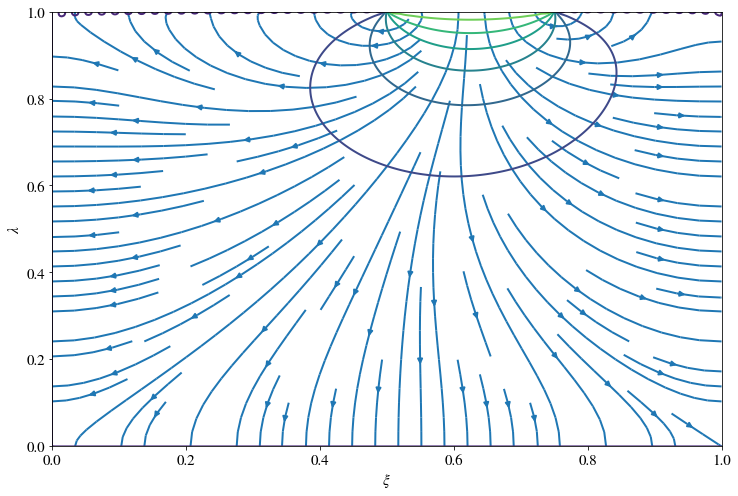

In [35]:
plt.streamplot(xx, yy, Ex_matrix, Ey_matrix)
plt.contour(xx, yy, V_matrix)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\lambda$")
plt.show()